# 构造分类器

In [1]:
from app_db import DB_ENGINE
import pandas as pd
from gensim.models.doc2vec import Doc2Vec

[2018-12-13 23:29:35] INFO    | summarizer.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


## 读取训练模型

In [2]:
model = Doc2Vec.load('RuntimeTY/doc2vec_minor_without_wordcutting')

[2018-12-13 23:29:38] INFO    | gensim.utils: loading Doc2Vec object from RuntimeTY/doc2vec_minor_without_wordcutting
[2018-12-13 23:29:39] INFO    | gensim.utils: loading vocabulary recursively from RuntimeTY/doc2vec_minor_without_wordcutting.vocabulary.* with mmap=None
[2018-12-13 23:29:39] INFO    | gensim.utils: loading trainables recursively from RuntimeTY/doc2vec_minor_without_wordcutting.trainables.* with mmap=None
[2018-12-13 23:29:39] INFO    | gensim.utils: loading syn1neg from RuntimeTY/doc2vec_minor_without_wordcutting.trainables.syn1neg.npy with mmap=None
[2018-12-13 23:29:41] INFO    | gensim.utils: loading wv recursively from RuntimeTY/doc2vec_minor_without_wordcutting.wv.* with mmap=None
[2018-12-13 23:29:41] INFO    | gensim.utils: loading vectors from RuntimeTY/doc2vec_minor_without_wordcutting.wv.vectors.npy with mmap=None
[2018-12-13 23:29:43] INFO    | gensim.utils: loading docvecs recursively from RuntimeTY/doc2vec_minor_without_wordcutting.docvecs.* with mmap=Non

## 读数据

In [3]:
raw_contents = pd.read_sql('SELECT rid, content, tag FROM rawcontents', DB_ENGINE, index_col='rid')
raw_contents.head()

,content,tag
rid,,
1,比特币现价41000元左右。至今年底最少跌去一半！立此帖为证。,1.0
2,破5000是大概率事件,1.0
3,估计到时候都是非去中心化的币才是追捧的对象。没有信用背书的币还是不太靠谱。,0.0
4,出天涯钻，5毛一个,1.0
5,,1.0


In [5]:
tagged_data = raw_contents[raw_contents['tag'].notnull()].copy()
tagged_data.head()

,content,tag
rid,,
1,比特币现价41000元左右。至今年底最少跌去一半！立此帖为证。,1.0
2,破5000是大概率事件,1.0
3,估计到时候都是非去中心化的币才是追捧的对象。没有信用背书的币还是不太靠谱。,0.0
4,出天涯钻，5毛一个,1.0
5,,1.0


In [6]:
tagged_data.describe()

,tag
count,2442.000000
mean,0.384930
std,0.486679
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 分类

In [28]:
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn import naive_bayes, ensemble

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

[2018-12-13 23:30:58] INFO    | matplotlib.font_manager: Could not open font file /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf


In [25]:
def printScores(scores):
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [9]:
X = list(tagged_data['content'].apply(model.infer_vector).values)
y = list(tagged_data['tag'].values)

#### 随机森林

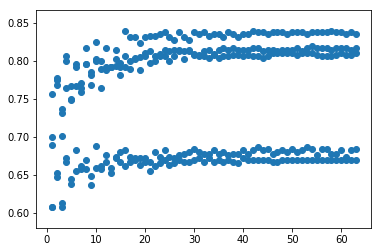

In [192]:
# clf = tree.DecisionTreeClassifier()
record = []

for n in range(1, 64):
    clf = ensemble.RandomForestClassifier(n_estimators=n, n_jobs=4)
    scores = cross_val_score(clf, X, y, cv=5)
    for score in scores:
        record.append((n, score))

df = pd.DataFrame(record, columns=['n_estimators', 'score'])
plt.scatter(df['n_estimators'], df['score'])

#### 支持向量机

In [191]:
from sklearn import svm

In [201]:
# clf = tree.DecisionTreeClassifier()
record = []

for c in np.linspace(0.5, 1.5, 11):
    for k in ['linear', 'rbf', 'sigmoid']:
        clf = svm.SVC(kernel=k, C=c, gamma='scale')
        scores = cross_val_score(clf, X, y, cv=5)
        for score in scores:
            record.append((c, k, score))

df = pd.DataFrame(record, columns=['C', 'kernel', 'score'])

ValueError: Could not interpret input 'kernel'

/home/lx/anaconda3/envs/ds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


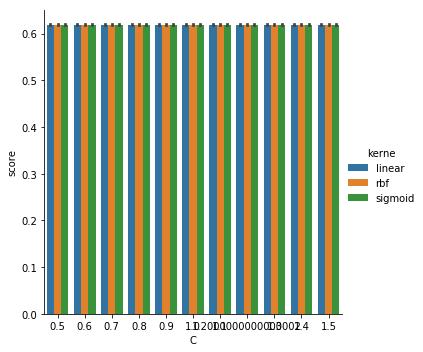

In [204]:
sns.catplot(x="C", y="score", hue='kernel', kind="bar", data=df);

#### 朴素贝叶斯

In [10]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

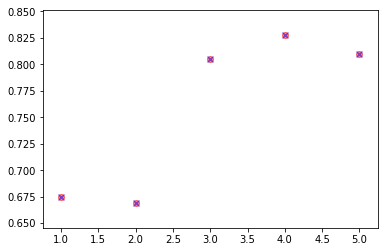

In [11]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=5)

plt.scatter(np.linspace(1,5,5),scores, c='r',marker='o', alpha=0.5)

bnb = BernoulliNB()
scores = cross_val_score(bnb, X, y, cv=5)

plt.scatter(np.linspace(1,5,5),scores, c='b',marker='x', alpha=0.5)

#### 决策树

In [13]:
from sklearn import tree

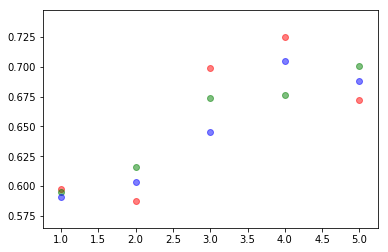

In [17]:
records = []

for max_feature, color in zip(['sqrt', 'log2', None], ['r', 'g', 'b']):
    clf = tree.DecisionTreeClassifier(max_features=max_feature)
    scores = cross_val_score(clf, X, y, cv=5)
    records.append((max_feature, scores))
    plt.scatter(np.linspace(1,5,5),scores, c=color,marker='o', alpha=0.5)

/home/lx/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


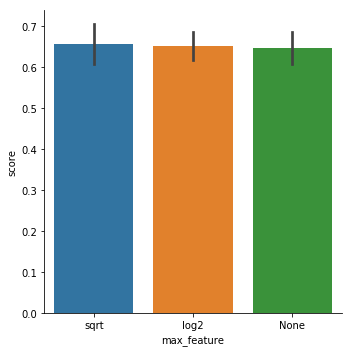

In [22]:
rec = []
for max_feature, scores in records:
    for score in scores:
        rec.append((max_feature if max_feature else "None", score))
        
df = pd.DataFrame(rec, columns=['max_feature', 'score'])
sns.catplot(x="max_feature", y="score", kind="bar", data=df);

#### 梯度下降

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

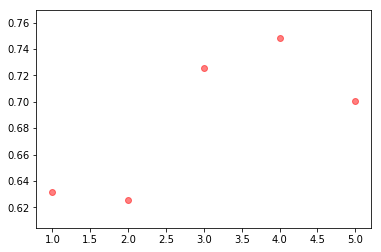

In [24]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
plt.scatter(np.linspace(1,5,5),scores, c='r', marker='o', alpha=0.5)

In [29]:
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5)

/home/lx/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.